In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
#mobile = keras.applications.mobilenet.MobileNet()
mobile = keras.applications.mobilenet_v2.MobileNetV2()

In [54]:
def prepare_image(file):
    img_path = "Data/"
    print(img_path + file)
    img = image.load_img(img_path + file, target_size = (224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

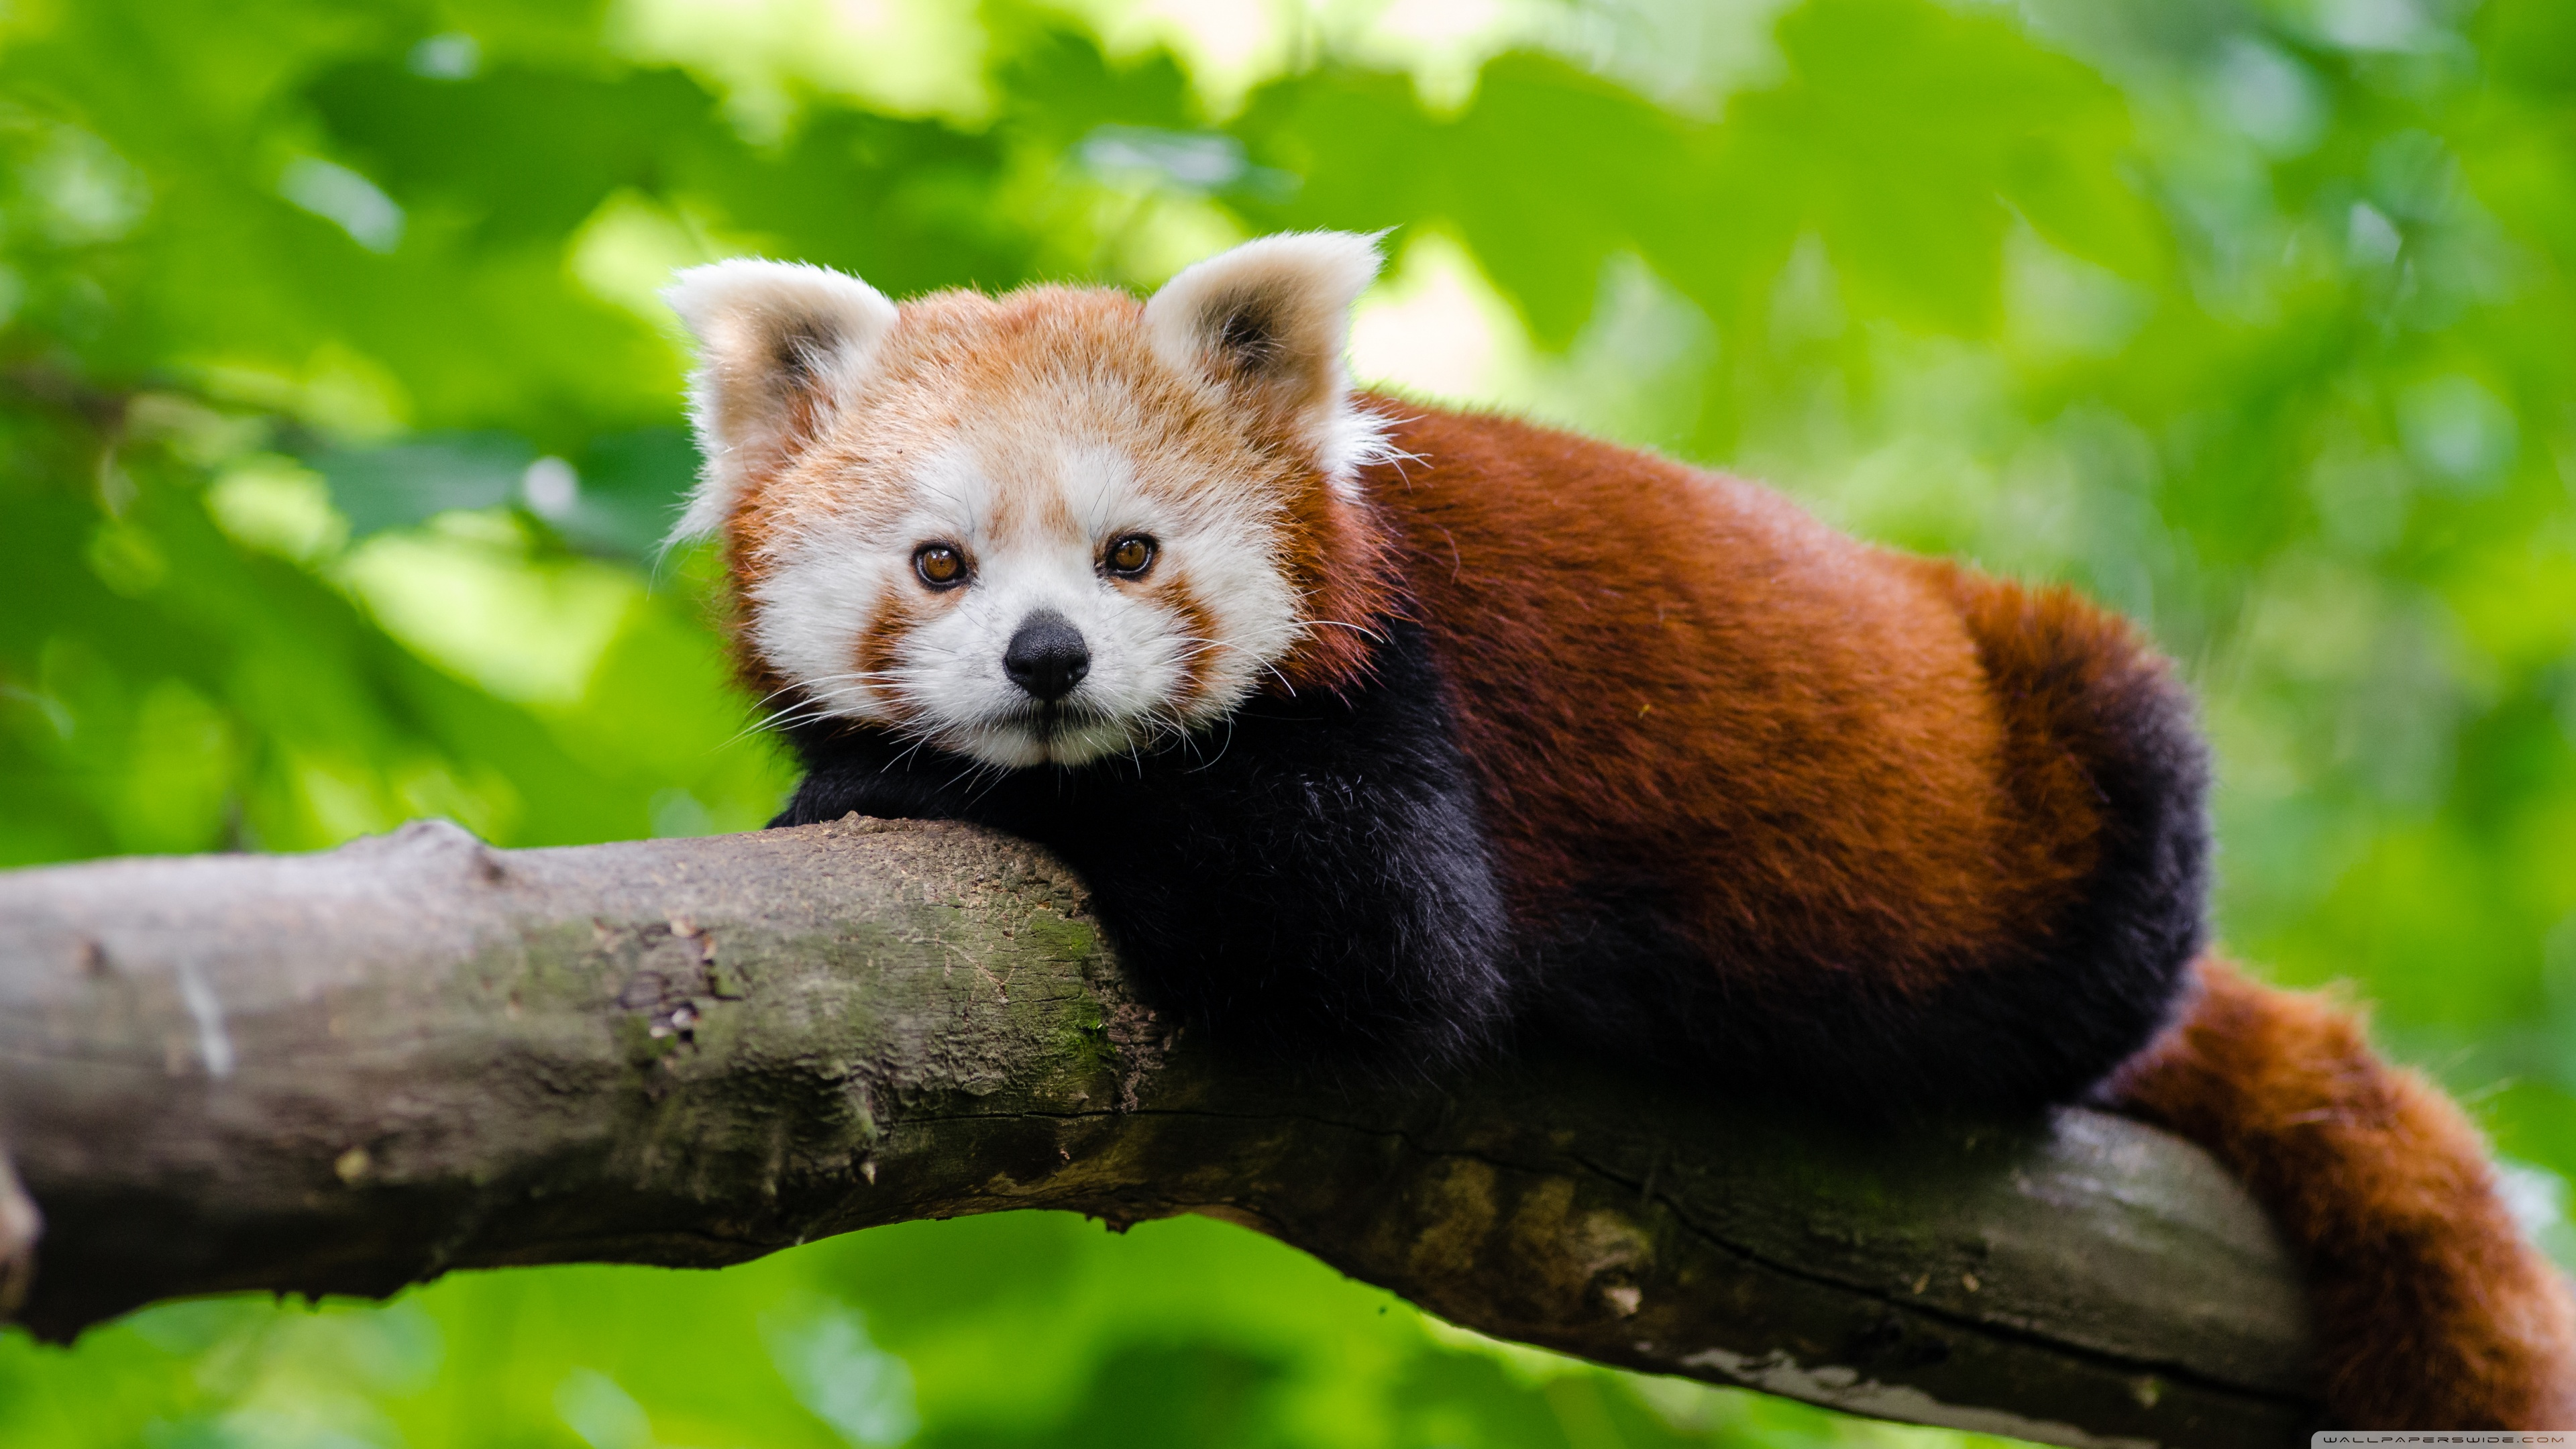

In [55]:
from IPython.display import Image
Image(filename='Data/image1.jpg', width=300, height=200)

In [56]:
preprocessed_image = prepare_image('image1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

Data/image1.jpg


[[('n02509815', 'lesser_panda', 0.9312769),
  ('n02443114', 'polecat', 0.006907721),
  ('n02441942', 'weasel', 0.0017250234),
  ('n02132136', 'brown_bear', 0.0016712295),
  ('n02510455', 'giant_panda', 0.0010975844)]]

In [57]:
train_path = 'Data_new/chest_xray/train'
valid_path = 'Data_new/chest_xray/val'
test_path = 'Data_new/chest_xray/test'

In [58]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                   train_path, 
                                   target_size = (224,224),
                                   batch_size = 32, 
                                   class_mode = 'categorical')
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                   valid_path, 
                                   target_size = (224,224),
                                   batch_size = 32, 
                                   class_mode = 'categorical')
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                   test_path, 
                                   target_size = (224,224),
                                   batch_size = 32, 
                                   class_mode = 'categorical', shuffle=False)

Found 760 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [59]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [60]:
x = mobile.layers[-6].output
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs= prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [61]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [62]:
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [63]:
 model.fit_generator(
  train_batches,
  validation_data=valid_batches,
  epochs=20,
  steps_per_epoch=len(train_batches),
  validation_steps=len(valid_batches),
  verbose = 2
)

Epoch 1/20


ValueError: A target array with shape (32, 2) was passed for an output of shape (None, 7, 7, 2) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_labels

In [ ]:
test_batches.class_indices

In [ ]:
predictions = model.predict_generator(test_batches, steps = len(test_batches), verbose=1)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
cm_plot_labels = ['normal','pnemonia']

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels)